<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 

ModuleNotFoundError: No module named 'haversine'

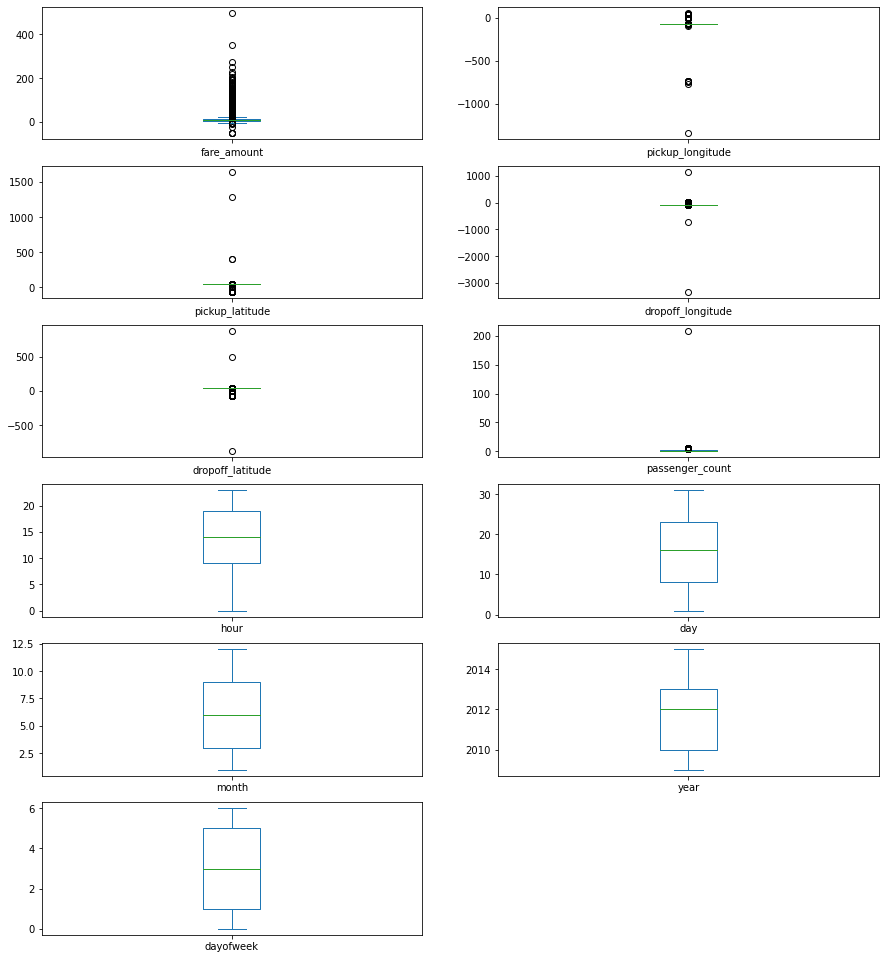

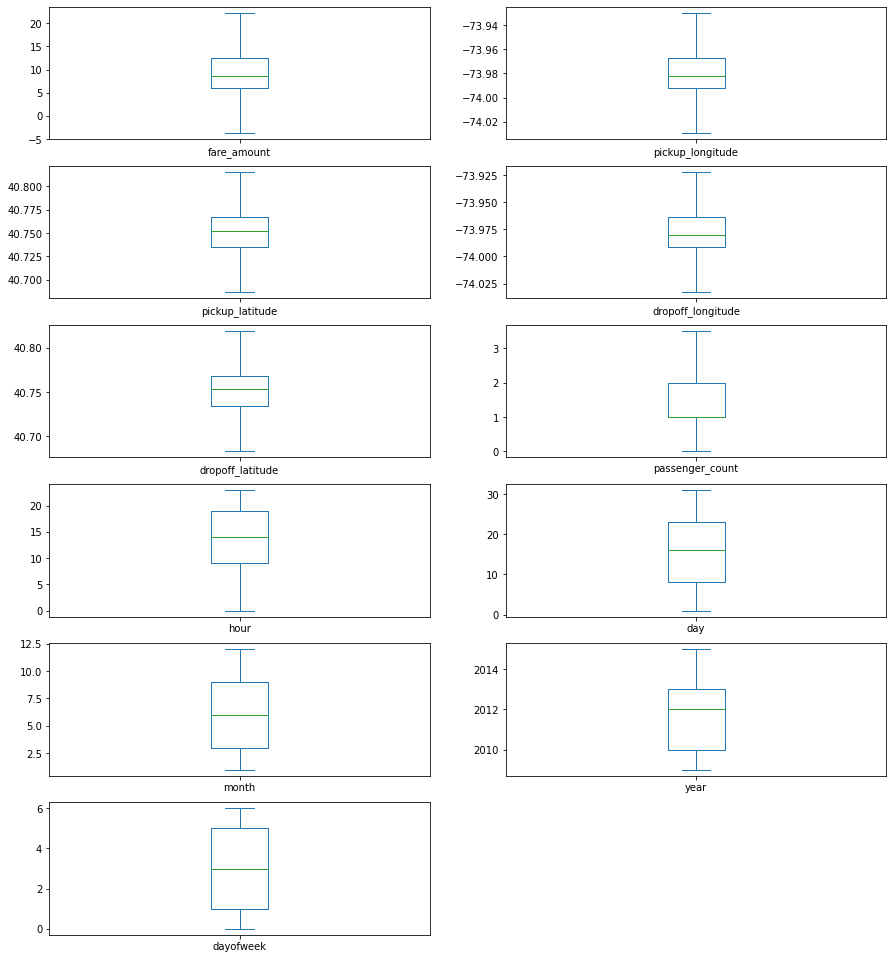

In [1]:
# #Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:
# 1.	Pre-process the dataset.
# 2.	Identify outliers.
# 3.	Check the correlation.
# 4.	Implement linear regression and random forest regression models.
# 5.	Evaluate the models and compare their respective scores like R2, RMSE, etc. Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#importing the dataset
df  = pd.read_csv('D:/4th_Year_subject_and_Practicals/4th_year_assignments/LP-3/ML/uber.csv')
##  1.	Pre-process the dataset.
df.head()
df.info() #To get the required information of the dataset
df.columns #TO get number of columns in the dataset
df = df.drop(['Unnamed: 0', 'key'], axis= 1) #To drop unnamed column as it isn't required
df.head()
df.shape #To get the total (Rows,Columns)
df.dtypes #To get the type of each column
df.info()

df.describe() #To get statistics of each columns 
### Filling Missing values
df.isnull().sum() 
df['dropoff_latitude'].fillna(value=df['dropoff_latitude'].mean(),inplace = True)
df['dropoff_longitude'].fillna(value=df['dropoff_longitude'].median(),inplace = True)
df.isnull().sum() 
df.dtypes
### Column pickup_datetime is in wrong format (Object). Convert it to DateTime Format
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce') 
df.dtypes
### To segregate each time of date and time
df= df.assign(hour = df.pickup_datetime.dt.hour,
             day= df.pickup_datetime.dt.day,
             month = df.pickup_datetime.dt.month,
             year = df.pickup_datetime.dt.year,
             dayofweek = df.pickup_datetime.dt.dayofweek)
df.head()
# drop the column 'pickup_daetime' using drop()
# 'axis = 1' drops the specified column

df = df.drop('pickup_datetime',axis=1)

df.head()
df.dtypes
## Checking outliers and filling them 
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) #Boxplot to check the outliers
#Using the InterQuartile Range to fill the values
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1
df = treat_outliers_all(df , df.iloc[: , 0::])
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) #Boxplot shows that dataset is free from outliers
#pip install haversine
import haversine as hs  #Calculate the distance using Haversine to calculate the distance between to points. Can't use Eucladian as it is for flat surface.
travel_dist = []
for pos in range(len(df['pickup_longitude'])):
        long1,lati1,long2,lati2 = [df['pickup_longitude'][pos],df['pickup_latitude'][pos],df['dropoff_longitude'][pos],df['dropoff_latitude'][pos]]
        loc1=(lati1,long1)
        loc2=(lati2,long2)
        c = hs.haversine(loc1,loc2)
        travel_dist.append(c)
    
print(travel_dist)
df['dist_travel_km'] = travel_dist
df.head()
#Uber doesn't travel over 130 kms so minimize the distance 
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)
#Finding inccorect latitude (Less than or greater than 90) and longitude (greater than or less than 180)
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')
df.head()
df.isnull().sum()
sns.heatmap(df.isnull()) #Free for null values
corr = df.corr() #Function to find the correlation
corr
fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot = True) #Correlation Heatmap (Light values means highly correlated)
### Dividing the dataset into feature and target values 
x = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month','year','dayofweek','dist_travel_km']]
y = df['fare_amount']
### Dividing the dataset into training and testing dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.33)
### Linear Regression
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(X_train,y_train)
regression.intercept_ #To find the linear intercept
regression.coef_ #To find the linear coeeficient
prediction = regression.predict(X_test) #To predict the target values
print(prediction)
y_test
### Metrics Evaluation using R2, Mean Squared Error, Root Mean Sqared Error
from sklearn.metrics import r2_score 
r2_score(y_test,prediction)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test,prediction)
MSE 
RMSE = np.sqrt(MSE)
RMSE
### Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100) #Here n_estimators means number of trees you want to build before making the prediction
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred
### Metrics evaluatin for Random Forest
R2_Random = r2_score(y_test,y_pred)
R2_Random
MSE_Random = mean_squared_error(y_test,y_pred)
MSE_Random
RMSE_Random = np.sqrt(MSE_Random)
RMSE_Random